<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro)**

В этом домашнем задании вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;
* реализовать веб-сервис для применения построенной модели на новых данных

> Оценка за домашку = $min(\text{ваш балл}, 11)$

**Мягкий дедлайн: 27 ноября 23:59**

**Жесткий дедлайн: 20 декабря 23:59 (конец модуля)**



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

random.seed(42)
np.random.seed(42)

### **Задание 0**
Для чего фиксируем сиды в домашках?

Для воспроизводимости результатов

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла)

In [3]:
df_train_with_nulls = df_train.columns[df_train.isnull().any()].tolist()
print(f'Пропуски в колонках в train:\n {df_train_with_nulls}')
df_test_with_nulls = df_test.columns[df_test.isnull().any()].tolist()
print(f'Пропуски в колонках в test:\n {df_test_with_nulls}')

if df_train.duplicated().any():
    print("В train есть дубликаты")
else:
    print("В train нет дубликатов")
if df_test.duplicated().any():
    print("В test есть дубликаты")
else:
    print("В test нет дубликатов")

Пропуски в колонках в train:
 ['mileage', 'engine', 'max_power', 'torque', 'seats']
Пропуски в колонках в test:
 ['mileage', 'engine', 'max_power', 'torque', 'seats']
В train есть дубликаты
В test есть дубликаты


In [4]:
from ydata_profiling import ProfileReport

df_full = pd.concat([df_train, df_test])
profile = ProfileReport(df_full, title="Data Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Выводы:

1. mileage, engine, max_power, torque - текстовые признаки, которые нужно преобразовать в числовые
2. torque записан в нестандартизованном виде. Есть rpm, Nm / kgm значения, возможно стоит разделить признак на два
3. Пропущенные значения есть только в mileage, engine, max_power, torque, seats
4. Пропущенные значения в перечисленных признаках почти всегда приходятся на одни и те же объекты
5. seller_type - несбалансированный признак: 83.3% значений приходятся на "Individual"
6. Необходимо удалить дубликаты


### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [5]:
df_train.describe(include=['number'])

year  selling_price     km_driven        seats
count  6999.000000   6.999000e+03  6.999000e+03  6797.000000
mean   2013.818403   6.395152e+05  6.958462e+04     5.419008
std       4.053095   8.089419e+05  5.772400e+04     0.965767
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.700000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000

In [6]:
df_test.describe(include=['number'])

year  selling_price      km_driven       seats
count  1000.000000   1.000000e+03    1000.000000  981.000000
mean   2013.681000   6.179010e+05   71393.341000    5.410805
std       4.012149   7.585539e+05   48486.218662    0.919985
min    1995.000000   3.100000e+04    1303.000000    4.000000
25%    2011.000000   2.500000e+05   37000.000000    5.000000
50%    2014.000000   4.349990e+05   61500.000000    5.000000
75%    2017.000000   6.700000e+05  100000.000000    5.000000
max    2020.000000   6.000000e+06  375000.000000    9.000000

In [7]:
df_train.describe(include=['object'])

name    fuel seller_type transmission        owner  \
count                     6999    6999        6999         6999         6999   
unique                    1924       4           3            2            5   
top     Maruti Swift Dzire VDI  Diesel  Individual       Manual  First Owner   
freq                       116    3793        5826         6095         4587   

          mileage   engine max_power          torque  
count        6797     6797      6803            6796  
unique        386      120       316             419  
top     18.9 kmpl  1248 CC    74 bhp  190Nm@ 2000rpm  
freq          197      885       330             468

In [8]:
df_test.describe(include=['object'])

name    fuel seller_type transmission        owner  \
count                  1000    1000        1000         1000         1000   
unique                  621       4           3            2            5   
top     Maruti Alto 800 LXI  Diesel  Individual       Manual  First Owner   
freq                     15     534         837          877          623   

          mileage   engine max_power          torque  
count         981      981       981             981  
unique        237       88       182             226  
top     18.6 kmpl  1248 CC    74 bhp  200Nm@ 1750rpm  
freq           23      116        43              57

Cреднее для признаков selling_price и km_driven заметно выше медианы, что говорит о наличии выбросов.

Среднее и медиана для train и test отличаются незначительно, явной разницы в распределении данных нет.

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.05 балла)
- [ ] Отобразите такие объекты (0.05 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.05 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.05 балла)

In [9]:
df_train_X = df_train.drop(columns=['selling_price'])
print(f'Количество дубликатов в train: {df_train_X.duplicated(keep="first").sum()}')

Количество дубликатов в train: 1159


In [10]:
# Объекты у которых есть дубликаты
df_train.drop_duplicates(subset=df_train_X.columns, keep='first', inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [11]:
assert df_train.shape == (5840, 13)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [12]:
df_train['mileage'] = df_train['mileage'].str.replace(' kmpl', '').str.replace(' km/kg', '').astype(float)
df_test['mileage'] = df_test['mileage'].str.replace(' kmpl', '').str.replace(' km/kg', '').astype(float)

df_train['engine'] = df_train['engine'].str.replace(' CC', '').astype(float)
df_test['engine'] = df_test['engine'].str.replace(' CC', '').astype(float)

df_train['max_power'] = pd.to_numeric(df_train['max_power'].str.replace(' bhp', ''), errors='coerce').astype(float)
df_test['max_power'] = pd.to_numeric(df_test['max_power'].str.replace(' bhp', ''), errors='coerce').astype(float)

In [13]:
def extract_torque(torque_string):
    if pd.isna(torque_string):
        return pd.NA, pd.NA
    torque_string = torque_string.lower().replace(' ', '')

    try:
        if '@' in torque_string:
            delimiter = '@'
        elif 'at' in torque_string:
            delimiter = 'at'
        else:
            return pd.NA, pd.NA
        
        if 'kgm' in torque_string:
            # convert to Nm
            torque_val = float(torque_string.split('kgm')[0].split(delimiter)[0])
            torque_val *= 9.80665
        else:
            torque_val = float(torque_string.split('nm')[0])
        
        if '-' in torque_string:
            rpm = float(torque_string.split(delimiter)[1].split('-')[0].replace('rpm', ''))
        else:
            rpm = float(torque_string.split(delimiter)[1].replace('rpm', '').replace('(', '').replace(')', ''))
    except:
        return pd.NA, pd.NA
    return torque_val, rpm

df_train['torque_nm'], df_train['max_torque_rpm'] = zip(*df_train['torque'].apply(extract_torque))
df_test['torque_nm'], df_test['max_torque_rpm'] = zip(*df_test['torque'].apply(extract_torque))
df_train['torque_nm'] = pd.to_numeric(df_train['torque_nm'], errors='coerce')
df_train['max_torque_rpm'] = pd.to_numeric(df_train['max_torque_rpm'], errors='coerce')
df_test['torque_nm'] = pd.to_numeric(df_test['torque_nm'], errors='coerce')
df_test['max_torque_rpm'] = pd.to_numeric(df_test['max_torque_rpm'], errors='coerce')
df_train = df_train.drop('torque', axis=1)
df_test = df_test.drop('torque', axis=1)

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






In [14]:
numeric_columns = df_train.select_dtypes(include=['float64']).columns
df_train[numeric_columns] = df_train[numeric_columns].fillna(df_train[numeric_columns].median())
df_test[numeric_columns] = df_test[numeric_columns].fillna(df_train[numeric_columns].median())
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5840 non-null   object 
 1   year            5840 non-null   int64  
 2   selling_price   5840 non-null   int64  
 3   km_driven       5840 non-null   int64  
 4   fuel            5840 non-null   object 
 5   seller_type     5840 non-null   object 
 6   transmission    5840 non-null   object 
 7   owner           5840 non-null   object 
 8   mileage         5840 non-null   float64
 9   engine          5840 non-null   float64
 10  max_power       5840 non-null   float64
 11  seats           5840 non-null   float64
 12  torque_nm       5840 non-null   float64
 13  max_torque_rpm  5840 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 638.9+ KB


Лучше применять медиану, потому что на среднее значение могут сильно влиять выбросы.

Верное утверждение: По тренировочным данным для `train` и `test`

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [15]:
df_train['engine'] = df_train['engine'].astype(int)
df_test['engine'] = df_test['engine'].astype(int)
df_train['seats'] = df_train['seats'].astype(int)
df_test['seats'] = df_test['seats'].astype(int)

Признак seats можно рассмотреть как категориальную переменную, потому что количество мест может быть только целым числом и принимает ограниченное количество значений.

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [16]:
df_train.describe()

year  selling_price     km_driven      mileage       engine  \
count  5840.000000   5.840000e+03  5.840000e+03  5840.000000  5840.000000   
mean   2013.428425   5.229601e+05  7.395224e+04    19.430841  1429.448973   
std       4.095622   5.354320e+05  6.007114e+04     3.985973   485.662834   
min    1983.000000   2.999900e+04  1.000000e+00     0.000000   624.000000   
25%    2011.000000   2.500000e+05  3.900000e+04    16.950000  1197.000000   
50%    2014.000000   4.050000e+05  7.000000e+04    19.370000  1248.000000   
75%    2017.000000   6.400000e+05  1.000000e+05    22.300000  1498.000000   
max    2020.000000   1.000000e+07  2.360457e+06    42.000000  3604.000000   

         max_power        seats    torque_nm  max_torque_rpm  
count  5840.000000  5840.000000  5840.000000     5840.000000  
mean     87.906371     5.426712   172.609313     2611.604966  
std      31.640418     0.982344    82.108996     1076.363869  
min       0.000000     2.000000    47.071920      175.000000  
25%      68.000000     5.000000   113.000000     1750.000000  
50%      81.860000     5.000000   170.000000     2000.000000  
75%      99.000000     5.000000   200.000000     3500.000000  
max     400.000000    14.000000   789.000000     5000.000000

In [17]:
df_test.describe()

year  selling_price      km_driven     mileage      engine  \
count  1000.000000   1.000000e+03    1000.000000  1000.00000  1000.00000   
mean   2013.681000   6.179010e+05   71393.341000    19.33881  1454.87600   
std       4.012149   7.585539e+05   48486.218662     3.95175   521.99574   
min    1995.000000   3.100000e+04    1303.000000     0.00000   624.00000   
25%    2011.000000   2.500000e+05   37000.000000    16.55000  1197.00000   
50%    2014.000000   4.349990e+05   61500.000000    19.37000  1248.00000   
75%    2017.000000   6.700000e+05  100000.000000    22.30000  1582.00000   
max    2020.000000   6.000000e+06  375000.000000    32.26000  3604.00000   

         max_power        seats    torque_nm  max_torque_rpm  
count  1000.000000  1000.000000  1000.000000     1000.000000  
mean     90.841670     5.403000   175.612770     2644.806000  
std      34.893389     0.912921    86.148185     1098.436225  
min      34.200000     4.000000    48.000000     1000.000000  
25%      69.000000     5.000000   112.000000     1750.000000  
50%      82.425000     5.000000   170.000000     2000.000000  
75%     102.000000     5.000000   204.250000     3750.000000  
max     280.000000     9.000000   620.000000     5000.000000

Заполнение пропусков не сдвинуло распределения, но могло возникнуть, если бы мы заполняли средними значениями

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

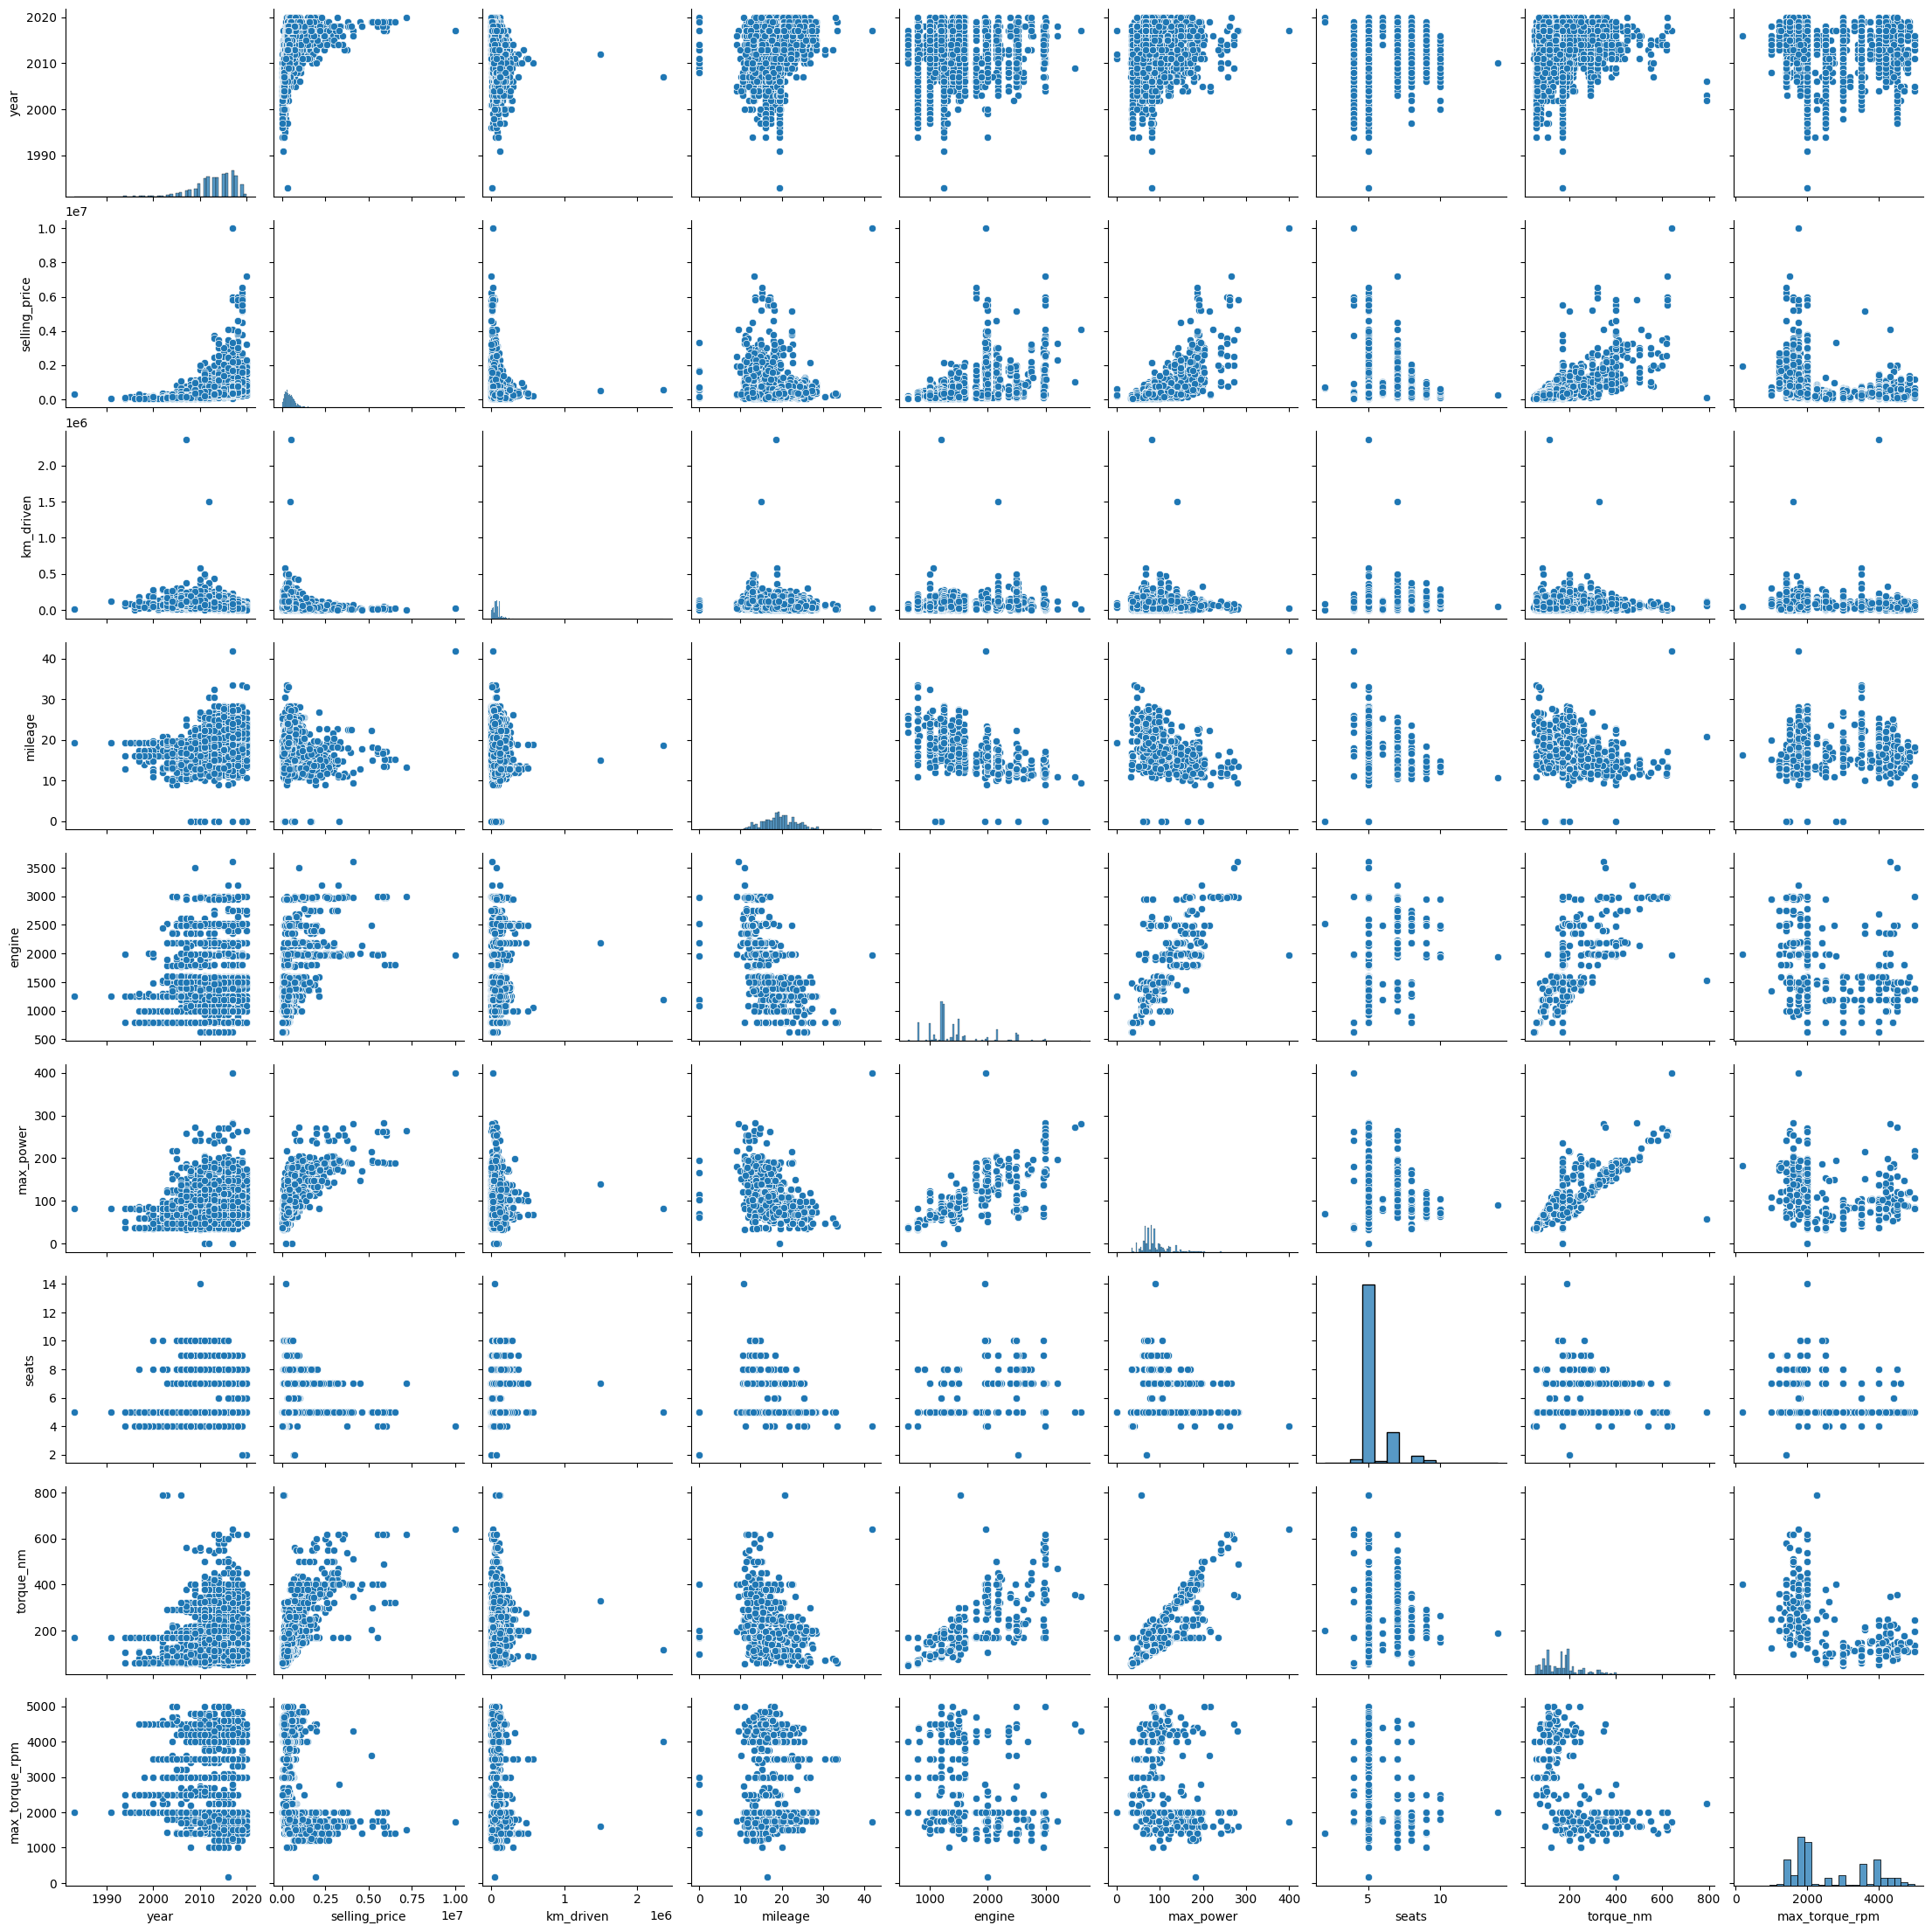

In [18]:
%matplotlib inline
import seaborn as sns


numeric_columns = df_train.select_dtypes(include=['float64', 'int64']).columns
sns.pairplot(df_train[numeric_columns])
plt.show()


Да, связь с целевой переменной видна на графисках. Например, чем новее автомобиль, те выше его стоимость. И, наоборот, чем больше пробег, тем ниже стоимость.

Да, видно что некоторые признаки сильно скоррелированы, например пары (max_power, torque_nm), (engine, torque_nm), (year, max_power)

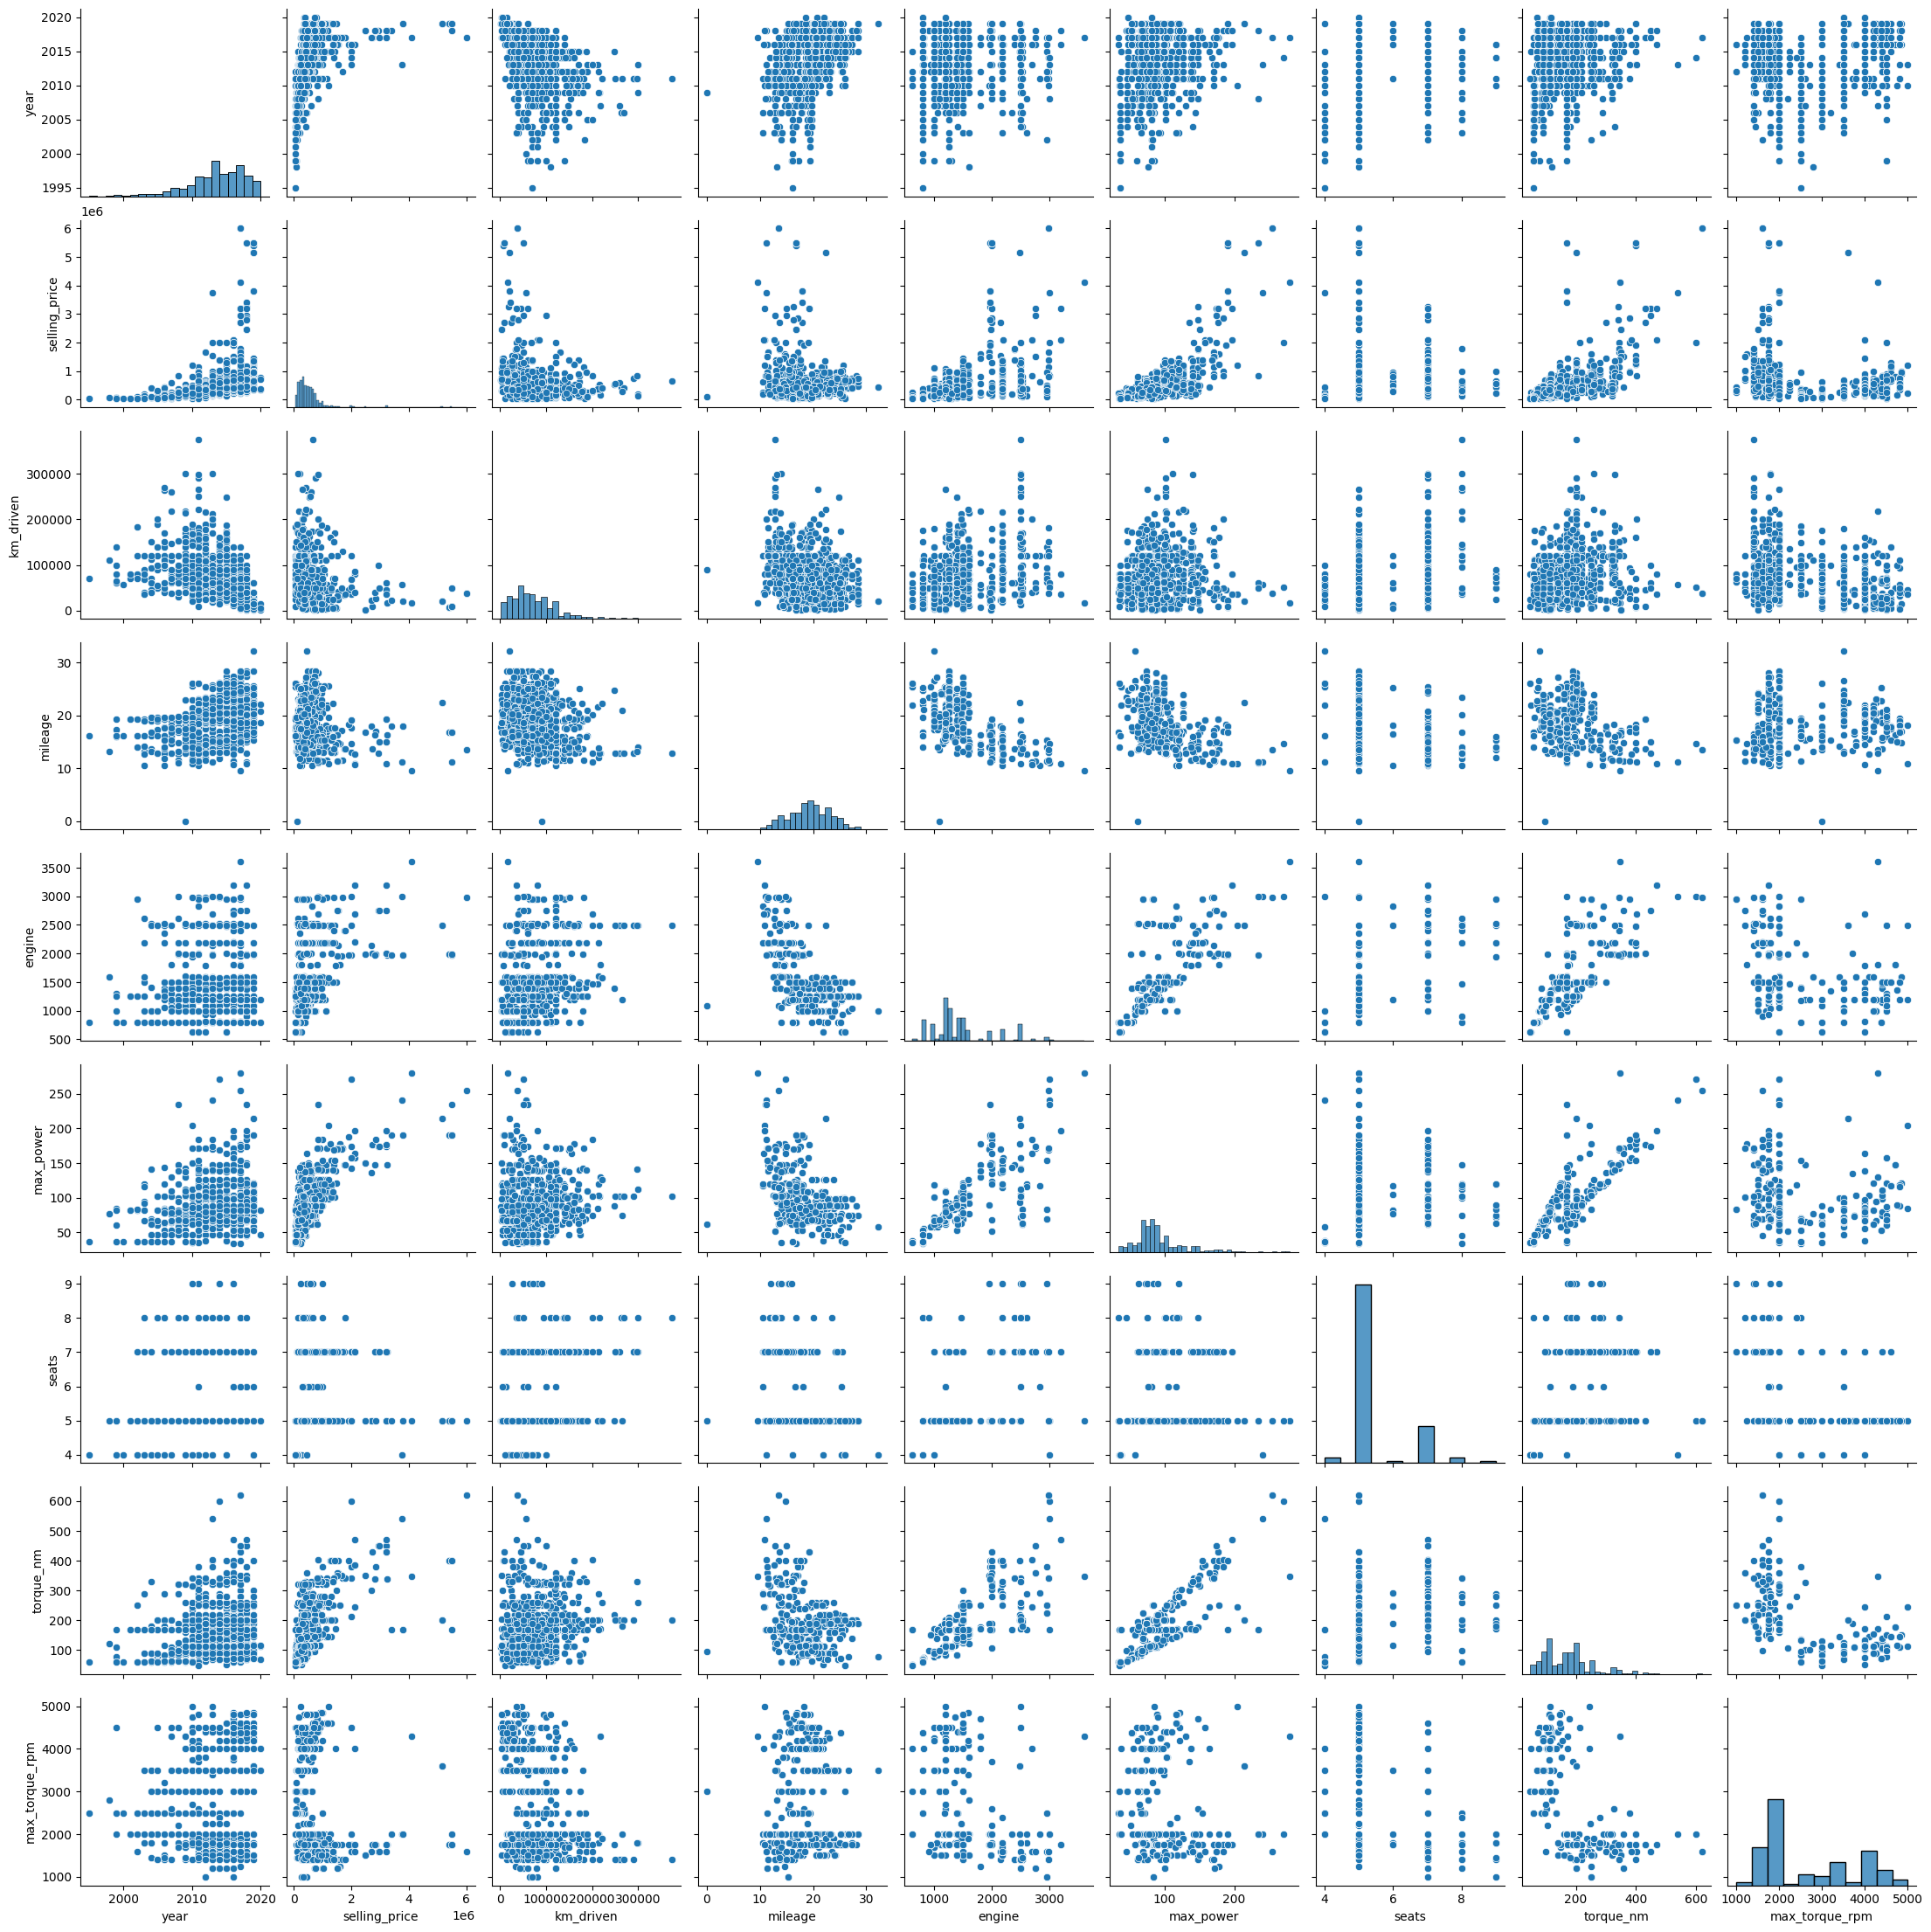

In [19]:
sns.pairplot(df_test[numeric_columns])
plt.show()

Да, совокупности при разделении на трейн и тест похожи

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

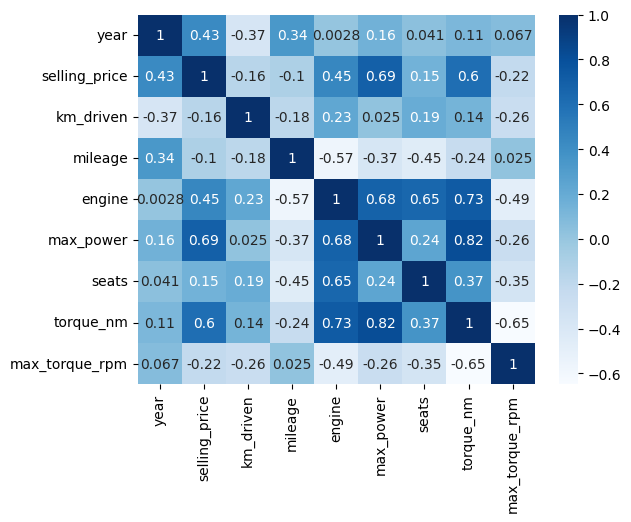

In [20]:
corr = df_train.corr(method='pearson', numeric_only=True)
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

Наименее скоррелированными признаками оказались engine и year.

Между признаками max_power и torque_nm наблюдается сильная положительная линейная зависимость. А также между engine и torque_nm, engine и max_power.

Правильно, у этих признаков отрицательная корреляция.

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ]

Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


In [21]:
def spearman_correlation(a, b):
    rank_a = np.argsort(np.argsort(a))
    rank_b = np.argsort(np.argsort(b))
    
    rank_diff_squared = np.sum((rank_a - rank_b) ** 2)
    n = len(a)
    
    return 1 - (6 * rank_diff_squared) / (n * (n**2 - 1))


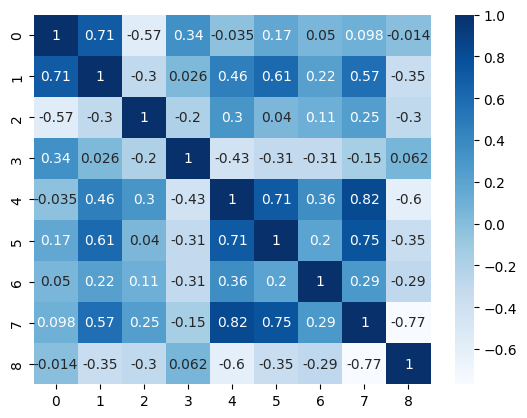

In [22]:
def spearman_correlation_matrix(df):
    n_cols = df.shape[1]
    cols = df.columns
    corr_matrix = np.zeros((n_cols, n_cols))
    
    for i in range(n_cols):
        for j in range(n_cols):
            corr_matrix[i,j] = spearman_correlation(df[cols[i]], df[cols[j]])
    
    return corr_matrix

corr = spearman_correlation_matrix(df_train[numeric_columns])
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

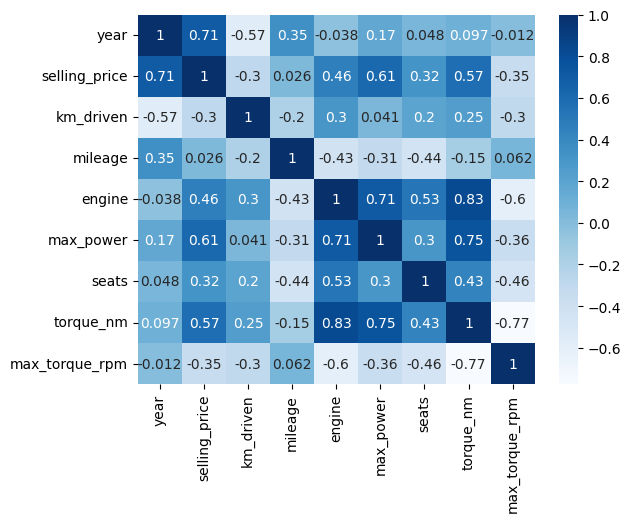

In [23]:
corr = df_train.corr(method='spearman', numeric_only=True)
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

In [24]:
import phik

plt.figure(figsize=(14,14))

ph = df_train[numeric_columns].phik_matrix()

ph.style.background_gradient(cmap='coolwarm')

interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'seats', 'torque_nm', 'max_torque_rpm']


<Figure size 1400x1400 with 0 Axes>

С целевой переменной сильнее всего коррелируют признаки max_power и torque_nm. В целом, наибольшую корреляцию имеют те же пары признаков, что и при корреляции Пирсона.

### **Дополнительные визуализации (бонус 0.2 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.

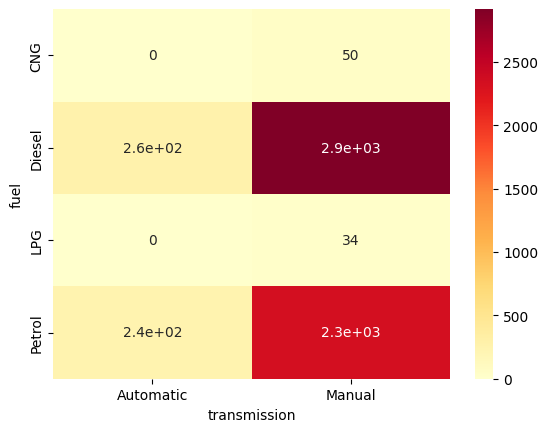

In [25]:
# Проверим взаимосвязь некоторых категориальных признаков
cross_tab = pd.crosstab(df_train['fuel'], df_train['transmission'])
sns.heatmap(cross_tab, annot=True, cmap='YlOrRd')
plt.show()

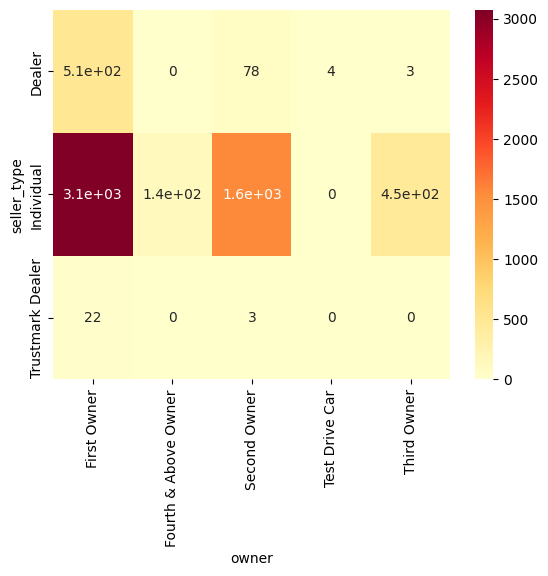

In [26]:
cross_tab = pd.crosstab(df_train['seller_type'], df_train['owner'])
sns.heatmap(cross_tab, annot=True, cmap='YlOrRd')
plt.show()

Редкие виды топлива (LPG, CNG) используются только в авто с механической трансмиссией.

Dealer и Trustmark Dealer в подавляющем большинстве случаев являются First Owner.

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [27]:

columns_numeric = ['km_driven', 'mileage', 'engine', 'max_power', 'seats', 'year', 'torque_nm', 'max_torque_rpm', 'selling_price']
df_train_numeric = df_train[columns_numeric].copy()
df_test_numeric = df_test[columns_numeric].copy()

y_train = df_train_numeric['selling_price']
X_train = df_train_numeric.drop(columns=['selling_price'])

In [28]:
# закомментировал assert, так как после разделения torque признаков стало больше
# assert X_train.shape == (5840, 6)

In [29]:
y_test = df_test_numeric['selling_price']
X_test = df_test_numeric.drop(columns=['selling_price'])

In [30]:
# закомментировал assert, так как после разделения torque признаков стало больше
# assert X_test.shape == (1000, 6)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f'R2 на обучающей выборке: {r2_score(y_train, y_pred_train):.4f}')
print(f'R2 на тестовой выборке: {r2_score(y_test, y_pred_test):.4f}')

print(f'MSE на обучающей выборке: {MSE(y_train, y_pred_train):.4f}')
print(f'MSE на тестовой выборке: {MSE(y_test, y_pred_test):.4f}')

R2 на обучающей выборке: 0.6006
R2 на тестовой выборке: 0.5946
MSE на обучающей выборке: 114469984604.4201
MSE на тестовой выборке: 233006954913.5334


Обученная модель объясняет чуть больше половины дисперсии целевой переменной. Значение MSE высокое как на обучающей выборке, так и на тестовой. Необходимо усложнить модель и поработать над признаками.

In [32]:
# сохраним предсказания для подсчета бизнес метрик
y_pred_test_model1 = y_pred_test

### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [33]:
def r2_score_np(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

r2_train = r2_score_np(y_train, y_pred_train)
r2_test = r2_score_np(y_test, y_pred_test)

print(f'R2 на обучающей выборке: {r2_train:.4f}')
print(f'R2 на обучающей выборке: {r2_test:.4f}')

R2 на обучающей выборке: 0.6006
R2 на обучающей выборке: 0.5946


ss_total - дисперсия зависимой переменной

ss_residual - дисперсия ошибки модели

r2_score - отношение между этими величинами

### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [34]:
def r2_score_np(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)
    
def adjusted_r2_score(y_true, y_pred, n, p):
    r2 = r2_score_np(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

n_train, p_train = X_train.shape
n_test, p_test = X_test.shape

adjusted_r2_train = adjusted_r2_score(y_train, y_pred_train, n_train, p_train)
adjusted_r2_test = adjusted_r2_score(y_test, y_pred_test, n_test, p_test)

print(f'Adjusted-R2 на обучающей выборке: {adjusted_r2_train:.4f}')
print(f'Adjusted-R2 на тестовой выборке: {adjusted_r2_test:.4f}')

Adjusted-R2 на обучающей выборке: 0.6001
Adjusted-R2 на тестовой выборке: 0.5914


Adgusted R^2 применяется для сравнения моделей обученных с разным числом предикторов

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

print(f'R2 на обучающей выборке: {r2_score(y_train, y_pred_train):.4f}')
print(f'R2 на тестовой выборке: {r2_score(y_test, y_pred_test):.4f}')

print(f'MSE на обучающей выборке: {MSE(y_train, y_pred_train):.4f}')
print(f'MSE на тестовой выборке: {MSE(y_test, y_pred_test):.4f}')


R2 на обучающей выборке: 0.6006
R2 на тестовой выборке: 0.5946
MSE на обучающей выборке: 114469984604.4203
MSE на тестовой выборке: 233006954913.5359


In [36]:
# сохраним предсказания для подсчета бизнес метрик
y_pred_test_model2 = y_pred_test

### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [37]:
max_index = np.argmax(np.abs(model.coef_))
print(f'Наиболее информативный признак: {X_train.columns[max_index]}, коэффициент: {model.coef_[max_index]}')

Наиболее информативный признак: max_power, коэффициент: 291406.112623527


### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [38]:
from sklearn.linear_model import Lasso

model = Lasso()
model.fit(X_train_scaled, y_train)
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

print(f'R2 на обучающей выборке: {r2_score(y_train, y_pred_train):.4f}')
print(f'R2 на тестовой выборке: {r2_score(y_test, y_pred_test):.4f}')

print(f'MSE на обучающей выборке: {MSE(y_train, y_pred_train):.4f}')
print(f'MSE на тестовой выборке: {MSE(y_test, y_pred_test):.4f}')
print(model.coef_)

R2 на обучающей выборке: 0.6006
R2 на тестовой выборке: 0.5946
MSE на обучающей выборке: 114469984617.5004
MSE на тестовой выборке: 233007654095.9478
[-49574.65422349  -5446.3015715   15481.94203667 291407.38863577
 -32377.5077204  165107.13329599  49246.21132519 -38608.47793494]


Качество модели практические не изменилось.

Никакие коэффициенты не занулились. Чтобы занулить некоторые коэффициенты для данного датасета, нужно увеличить значение параметра регуляризации.

In [39]:
# сохраним предсказания для подсчета бизнес метрик
y_pred_test_model3 = y_pred_test

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [40]:
from sklearn.model_selection import GridSearchCV

model = Lasso()
param_grid = {'alpha': [0.5, 1, 10, 100, 10000], 'max_iter': [1000, 2000], 'tol': [1e-4, 1e-3]}
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
print(grid_search.best_params_)


{'alpha': 10000, 'max_iter': 1000, 'tol': 0.001}


In [41]:
grid_search.best_estimator_.coef_


array([-40149.28021563,      0.        ,      0.        , 287110.38420346,
        -6600.88699848, 154162.05605454,  58119.5905172 , -19407.20424895])

grid_search обучал 200 моделей (5 alpha * 2 max_iter * 2 tol * 10 фолдов) для поиска оптимальных параметров + 1 модель обученная на всех данных (grid_search.best_estimator_).

alpha - коэффициент регуляризации

max_iter - максимальное число итераций оптимизации

tol - критерий остановки оптимизации


У лучшей модели коэффициент регуляризации alpha = 10000.

Занулились веса для признаков mileage и engine.


In [42]:
# сохраним предсказания для подсчета бизнес метрик
y_pred_test_model4 = grid_search.best_estimator_.predict(X_test_scaled)

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [43]:
from sklearn.linear_model import ElasticNet

model = ElasticNet()
param_grid = {'alpha': [0.1, 0.5, 1, 10, 100, 1000, 10000], 'l1_ratio': [0.01, 0.1, 0.5, 0.9, 1]}
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
print(grid_search.best_params_)


{'alpha': 10000, 'l1_ratio': 1}


grid_search обучал 350 моделей для поиска оптимальных параметров + 1 модель обученная на всех данных (grid_search.best_estimator_).

У лучшей модели alpha = 10000, l1_ratio = 1

In [44]:
# сохраним предсказания для подсчета бизнес метрик
y_pred_test_model5 = grid_search.best_estimator_.predict(X_test_scaled)

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



In [45]:
# your code here

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [46]:
X_train_cat = X_train.copy()
X_train_cat['name'] = df_train['name'].apply(lambda x: x.split(' ')[0])
X_train_cat['fuel'] = df_train['fuel']
X_train_cat['seller_type'] = df_train['seller_type']
X_train_cat['transmission'] = df_train['transmission']
X_train_cat['owner'] = df_train['owner']

X_test_cat = X_test.copy()
X_test_cat['name'] = df_test['name'].apply(lambda x: x.split(' ')[0])
X_test_cat['fuel'] = df_test['fuel']
X_test_cat['seller_type'] = df_test['seller_type']
X_test_cat['transmission'] = df_test['transmission']
X_test_cat['owner'] = df_test['owner']


In [47]:
# закомментировал assert, так как после разделения torque признаков стало больше
# assert X_train_cat.shape == (5840, 11)

In [48]:
X_train_cat.describe(include='object')

name    fuel seller_type transmission        owner
count     5840    5840        5840         5840         5840
unique      30       4           3            2            5
top     Maruti  Diesel  Individual       Manual  First Owner
freq      1804    3177        5223         5336         3603

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [49]:
from sklearn.preprocessing import OneHotEncoder # или можно использовать get_dummies из библиотеки pandas

columns_for_ohe = ['name', 'fuel', 'seller_type', 'transmission', 'owner', 'seats']
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
X_train_cat_ohe = ohe.fit_transform(X_train_cat[columns_for_ohe])
X_test_cat_ohe = ohe.transform(X_test_cat[columns_for_ohe])

X_train_cat = np.hstack([X_train_cat_ohe, X_train_cat.drop(columns=columns_for_ohe).values])
X_test_cat = np.hstack([X_test_cat_ohe, X_test_cat.drop(columns=columns_for_ohe).values])


/Users/kershov/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [50]:
X_train_cat.shape, X_test_cat.shape

((5840, 54), (1000, 54))

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

Если категория встречается редко, выделение ее в отдельный столбец может ухудшить обобщающую способность модели. Редкие категории можно отнести к категории "other". Если количество категорий слишком велико, можно использовать другой метод кодирования, например Target Encoding. При применении модели на новых данных важно сохранять порядок категорий.

Один столбец удаляется для того, чтобы избежать проблемы мультиколлинеарности.

При большом количестве категорий отдельные веса могут быть небольшими, но в совокупности они могут сильно повлиять на итоговый результат. Удалять признаки только на основании весов некорректно.


### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [51]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
X_train_cat_scaled = scaler.fit_transform(X_train_cat)
X_test_cat_scaled = scaler.transform(X_test_cat)

model = Ridge()
param_grid = {'alpha': [0.1, 0.5, 1, 10, 100, 1000, 10000]}
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='r2')
grid_search.fit(X_train_cat_scaled, y_train)
print(grid_search.best_params_)


{'alpha': 1000}


In [52]:
y_pred_train = grid_search.best_estimator_.predict(X_train_cat_scaled)
y_pred_test = grid_search.best_estimator_.predict(X_test_cat_scaled)

print(f'R2 на обучающей выборке: {r2_score(y_train, y_pred_train):.4f}')
print(f'R2 на тестовой выборке: {r2_score(y_test, y_pred_test):.4f}')

print(f'MSE на обучающей выборке: {MSE(y_train, y_pred_train):.4f}')
print(f'MSE на тестовой выборке: {MSE(y_test, y_pred_test):.4f}')

R2 на обучающей выборке: 0.7707
R2 на тестовой выборке: 0.7794
MSE на обучающей выборке: 65730321277.0705
MSE на тестовой выборке: 126796731103.8996


Качество прогнозов заметно выросло, добавление категориальных признаков улучшило результат

In [53]:
# сохраним предсказания для подсчета бизнес метрик
y_pred_test_final = y_pred_test


# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 2-х баллов в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [54]:
# your code here

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [55]:
def business_metrics(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true) <= 0.1)

print(business_metrics(y_test, y_pred_test_model1))
print(business_metrics(y_test, y_pred_test_model2))
print(business_metrics(y_test, y_pred_test_model3))
print(business_metrics(y_test, y_pred_test_model4))
print(business_metrics(y_test, y_pred_test_model5))
print(business_metrics(y_test, y_pred_test_final))


0.24
0.24
0.24
0.241
0.241
0.293


Лучше всего задачу бизнеса решает последняя модель обученная с категориальными признаками (29.3%)

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [56]:
def your_business_metrics(y_true, y_pred, penalty_score=2):
    abs_errors = np.abs(y_true - y_pred)
    
    # штрафуем предсказания меньше истинного значения в penalty_score раз
    penalties = np.where(y_pred < y_true, penalty_score * abs_errors, abs_errors)
    return np.mean(penalties)

print(your_business_metrics(y_test, y_pred_test_model1))
print(your_business_metrics(y_test, y_pred_test_model2))
print(your_business_metrics(y_test, y_pred_test_model3))
print(your_business_metrics(y_test, y_pred_test_model4))
print(your_business_metrics(y_test, y_pred_test_model5))
print(your_business_metrics(y_test, y_pred_test_final))


358582.9343906014
358582.9343906103
358582.5038965677
356375.7847755838
356352.4358795169
253752.84086119907


In [57]:
import pickle


with open('ridge_model.pkl', 'wb') as f:
    pickle.dump({
        'model': grid_search.best_estimator_,
        'scaler': scaler,
        'columns_for_ohe': columns_for_ohe,
        'ohe': ohe
    }, f)


Лучше всего задачу бизнеса решает последняя модель обученная с категориальными признаками, она дает минимальное значение кастомной метрики

# **Часть 5 (3 балла) | Реализация сервиса на FastAPI**

### **Задание 25**

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

In [58]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List

app = FastAPI()


class Item(BaseModel):
    name: str
    year: int
    selling_price: int
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: str
    engine: str
    max_power: str
    torque: str
    seats: float


class Items(BaseModel):
    objects: List[Item]


@app.post("/predict_item")
def predict_item(item: Item) -> float:
    return ...


@app.post("/predict_items")
def predict_items(items: List[Item]) -> List[float]:
    return ...

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 26**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете в md-файл приложить ссылку на screencast с демонстрацией

3. Просматривает ноутбук с DS частью
4. Заглядывает в код сервиса
5. Хвалит

# **Часть Благодарственная**

Надеемся, вы честно проделали все пункты, а не просто пролистали досюда. Потому что здесь награда за старания. Пожалуйста, не стоит награждать себя до того, как закончите работать над домашкой.

<details>
<summary><b>Что-то приятное</b></summary>

**Напоминаем, что нашем курсе действует система кото-бонусов** 🐈

На фото по ссылке — сэр кот кого-то из команды курса (преподаватель, помощник преподавателя, ассистенты).

Предлагаем вам угадать — чей это товарищ!

[Первый кот](https://ibb.co/Kz1ZRWj)

</details>

Предположу что это кот Елены